<a href="https://colab.research.google.com/github/InduwaraGayashan001/TensorFlow/blob/main/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import os
import numpy as np
import cv2
import glob as glob

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from zipfile import ZipFile
from urllib.request import urlretrieve

import warnings
import logging
import absl

# Filter absl warnings
warnings.filterwarnings("ignore", module="absl")

# Capture all warnings in the logging system
logging.captureWarnings(True)

# Set the absl logger level to 'error' to suppress warnings
absl_logger = logging.getLogger("absl")
absl_logger.setLevel(logging.ERROR)

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Extract Data

In [2]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)
URL = r"https://www.dropbox.com/s/wad5js22fbeo1be/camvid_images.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "camvid_images.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

In [3]:
image_paths = sorted(glob.glob("camvid_images" + os.sep + "*.png"))

for idx in range(len(image_paths)):
    print(image_paths[idx])

camvid_images/camvid_sample_1.png
camvid_images/camvid_sample_2.png
camvid_images/camvid_sample_3.png
camvid_images/camvid_sample_4.png


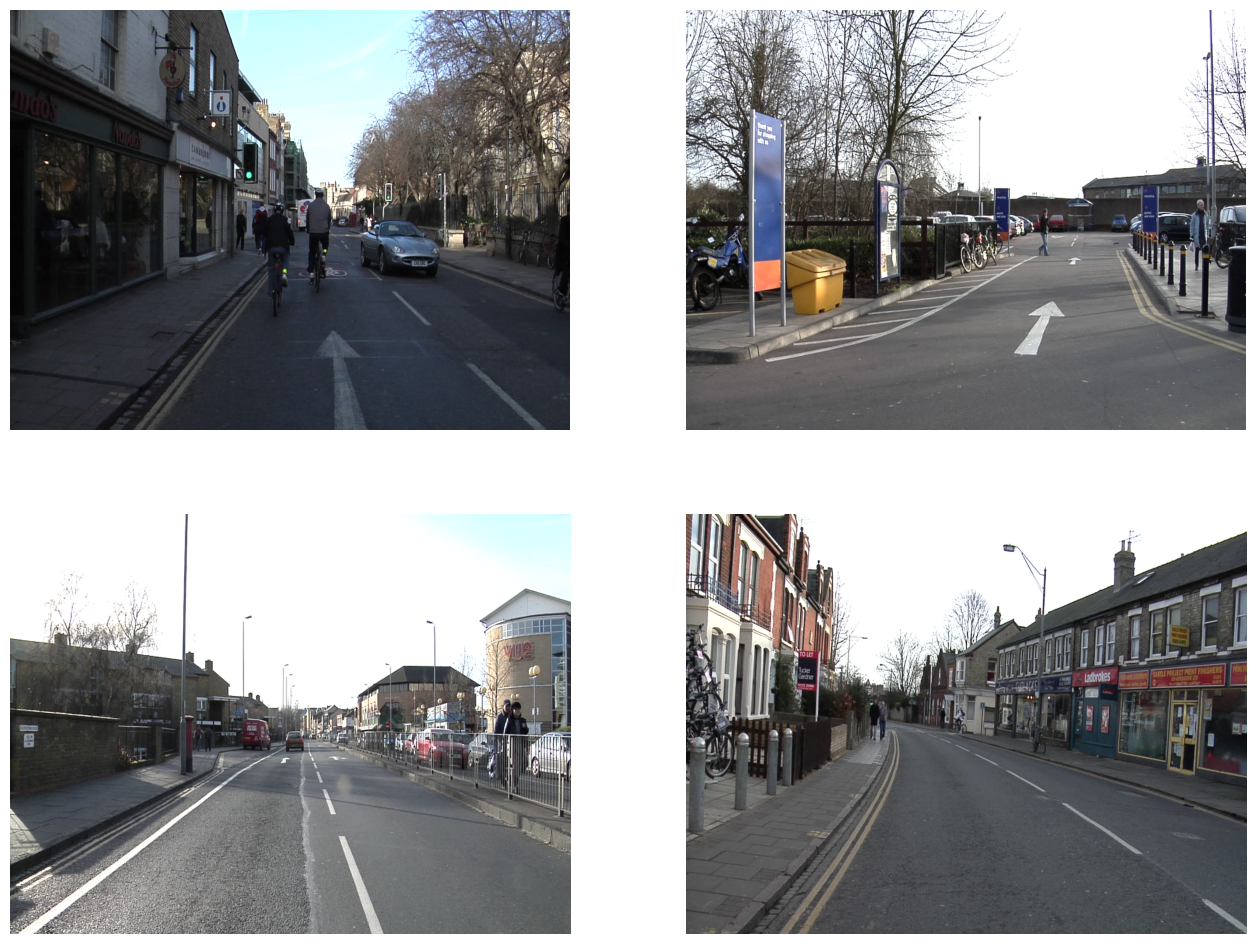

In [4]:
def load_image(path):
    image = cv2.imread(path)

    # Convert image in BGR format to RGB.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Add a batch dimension which is required by the model.
    image = np.expand_dims(image, axis=0) / 255.0

    return image
images = []
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

for idx, axis in enumerate(ax.flat):
    image = load_image(image_paths[idx])
    images.append(image)
    axis.imshow(image[0])
    axis.axis("off")

In [5]:
class_index = \
    {
         0: [(64, 128, 64),  'Animal'],
         1: [(192, 0, 128),  'Archway'],
         2: [(0, 128, 192),  'Bicyclist'],
         3: [(0, 128, 64),   'Bridge'],
         4: [(128, 0, 0),    'Building'],
         5: [(64, 0, 128),   'Car'],
         6: [(64, 0, 192),   'Cart/Luggage/Pram'],
         7: [(192, 128, 64), 'Child'],
         8: [(192, 192, 128),'Column Pole'],
         9: [(64, 64, 128),  'Fence'],
        10: [(128, 0, 192),  'LaneMkgs Driv'],
        11: [(192, 0, 64),   'LaneMkgs NonDriv'],
        12: [(128, 128, 64), 'Misc Text'],
        13: [(192, 0, 192),  'Motorcycle/Scooter'],
        14: [(128, 64, 64),  'Other Moving'],
        15: [(64, 192, 128), 'Parking Block'],
        16: [(64, 64, 0),    'Pedestrian'],
        17: [(128, 64, 128), 'Road'],
        18: [(128, 128, 192),'Road Shoulder'],
        19: [(0, 0, 192),    'Sidewalk'],
        20: [(192, 128, 128),'Sign Symbol'],
        21: [(128, 128, 128),'Sky'],
        22: [(64, 128, 192), 'SUV/Pickup/Truck'],
        23: [(0, 0, 64),     'Traffic Cone'],
        24: [(0, 64, 64),    'Traffic Light'],
        25: [(192, 64, 128), 'Train'],
        26: [(128, 128, 0),  'Tree'],
        27: [(192, 128, 192),'Truck/Bus'],
        28: [(64, 0, 64),    'Tunnel'],
        29: [(192, 192, 0),  'Vegetation Misc'],
        30: [(0, 0, 0),      'Void'],
        31: [(64, 192, 0),   'Wall']
    }

# Model Inference

In [7]:
model_url = "https://tfhub.dev/google/HRNet/camvid-hrnetv2-w48/1"
print("Downloading model from:", model_url)
seg_model = hub.load(model_url)
print("Model loaded.")

Model loaded.


In [8]:
pred_mask = seg_model.predict(images[0])
print(f"Shape of the predicted mask: {pred_mask.shape}")

Shape of the predicted mask: (1, 720, 960, 33)


In [9]:
pred_mask = pred_mask.numpy()
pred_mask = pred_mask[:,:,:,1:]
pred_mask = np.squeeze(pred_mask)
print(f"Shape of the predicted mask: {pred_mask.shape}")

Shape of the predicted mask: (720, 960, 32)


(np.float64(-0.5), np.float64(959.5), np.float64(719.5), np.float64(-0.5))

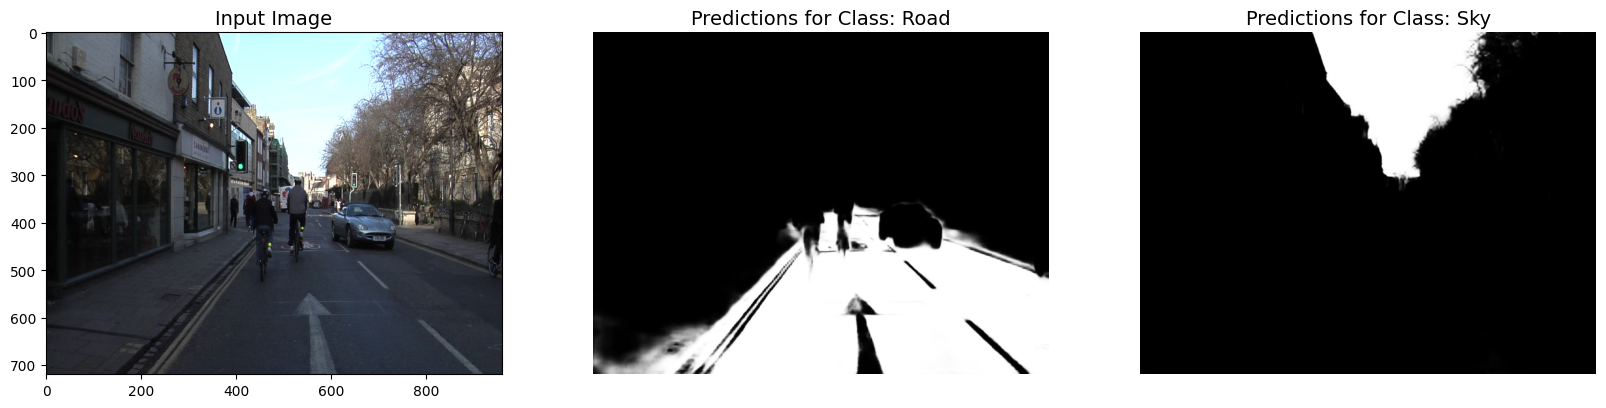

In [10]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.title("Input Image", fontsize=14)
plt.imshow(np.squeeze(images[0]))

plt.subplot(1, 3, 2)
plt.title("Predictions for Class: Road", fontsize=14)
plt.imshow(pred_mask[:, :, 17], cmap="gray") # Class 17 corresponds to the 'road' class
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Predictions for Class: Sky", fontsize=14)
plt.imshow(pred_mask[:, :, 21], cmap="gray") # Class 21 corresponds to the 'sky' class
plt.axis("off")

In [15]:
pred_mask[200, 300:700:,21]

array([4.24555466e-08, 5.93924980e-08, 7.88391006e-08, 9.93031506e-08,
       1.25079580e-07, 1.57546296e-07, 1.97613730e-07, 2.46838880e-07,
       3.08325923e-07, 3.85129113e-07, 4.76054623e-07, 5.82318819e-07,
       7.12305791e-07, 8.71305360e-07, 9.94226752e-07, 1.05830736e-06,
       1.12651776e-06, 1.19912409e-06, 1.23952043e-06, 1.24425162e-06,
       1.24899941e-06, 1.25376550e-06, 1.14376712e-06, 9.48255433e-07,
       7.86164662e-07, 6.51782159e-07, 6.01599197e-07, 6.18203444e-07,
       6.35264655e-07, 6.52797269e-07, 6.54982216e-07, 6.41665793e-07,
       6.28619546e-07, 6.15839099e-07, 5.73811008e-07, 5.08502126e-07,
       4.50626345e-07, 3.99337438e-07, 3.35995423e-07, 2.68408456e-07,
       2.14416758e-07, 1.71285649e-07, 2.45222168e-07, 6.29178089e-07,
       1.61430603e-06, 4.14185388e-06, 7.36586617e-06, 9.07979756e-06,
       1.11925501e-05, 1.37969009e-05, 1.03589773e-05, 4.73732507e-06,
       2.16643707e-06, 9.90732133e-07, 6.54845451e-07, 6.25593941e-07,
      

In [11]:
pred_mask_class = np.argmax(pred_mask, axis=-1)
print(f"Shape of the predicted mask: {pred_mask_class.shape}")

Shape of the predicted mask: (720, 960)


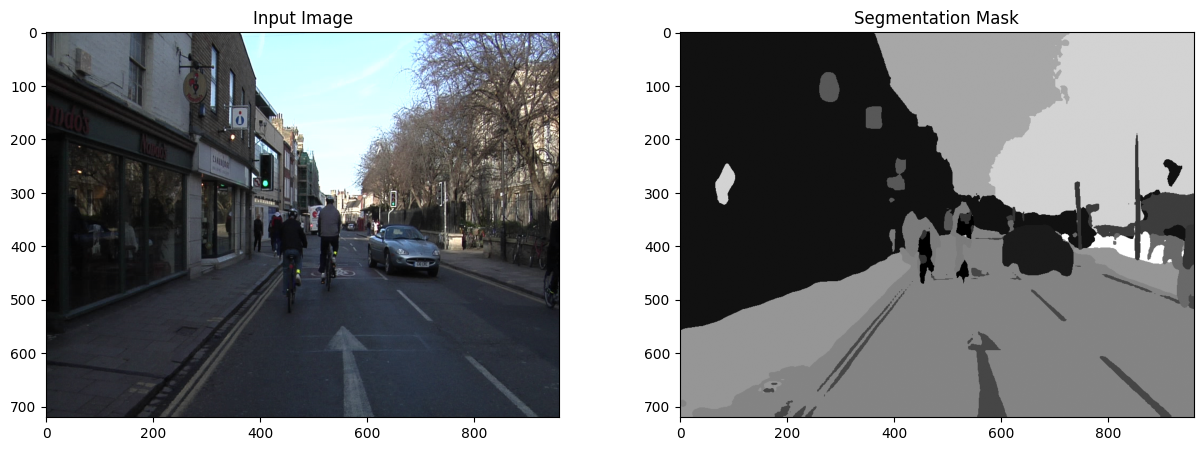

In [13]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Input Image", fontsize=12)
plt.imshow(np.squeeze(images[0]))

plt.subplot(1, 2, 2)
plt.title("Segmentation Mask", fontsize=12)
plt.imshow(pred_mask_class, cmap="gray")

In [14]:
pred_mask_class[200,300:700]

array([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21

In [16]:
def class_to_rgb(mask_class, class_index):

    r_map = np.zeros_like(mask_class).astype(np.uint8)
    g_map = np.zeros_like(mask_class).astype(np.uint8)
    b_map = np.zeros_like(mask_class).astype(np.uint8)

    for class_id in range(len(class_index)):
        index = mask_class == class_id
        r_map[index] = class_index[class_id][0][0]
        g_map[index] = class_index[class_id][0][1]
        b_map[index] = class_index[class_id][0][2]

    rgb_map = np.stack([r_map, g_map, b_map], axis=2)

    return rgb_map


In [17]:
pred_mask_rgb = class_to_rgb(pred_mask_class, class_index)
print(f"Shape of the predicted mask: {pred_mask_rgb.shape}")

Shape of the predicted mask: (720, 960, 3)


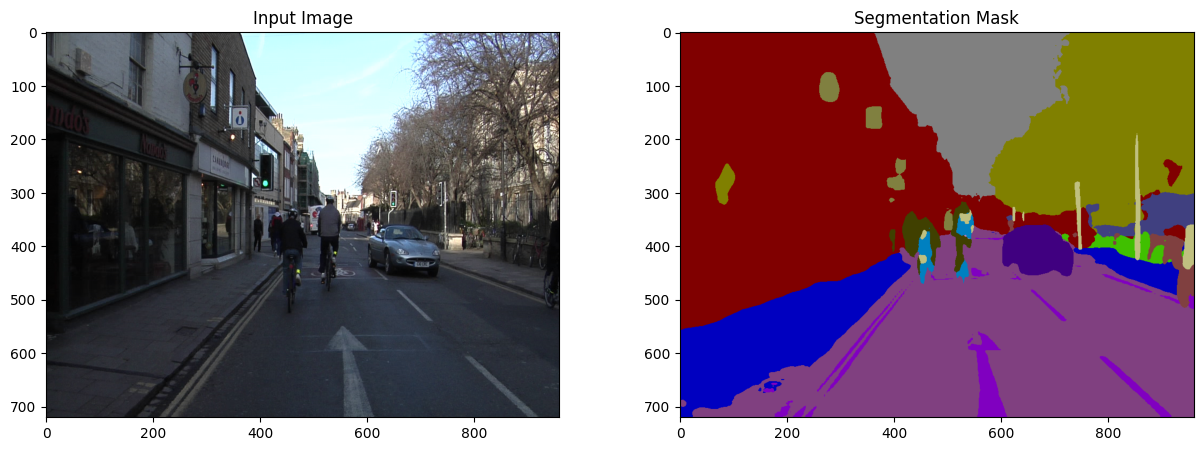

In [18]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Input Image", fontsize=12)
plt.imshow(np.squeeze(images[0]))

plt.subplot(1, 2, 2)
plt.title("Segmentation Mask", fontsize=12)
plt.imshow(pred_mask_rgb)

In [19]:
def image_overlay(image, seg_map_rgb):

  alpha = 1.0
  beta = 0.6
  gamma = 0.0

  image = (image * 255.0).astype(np.uint8)
  seg_map_rgb = cv2.cvtColor(seg_map_rgb, cv2.COLOR_RGB2BGR)

  image = cv2.addWeighted(image, alpha, seg_map_rgb, beta, gamma)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  return image

In [20]:
def run_inference(images, model):

  for img in images:

    pred_mask = model.predict(img)
    pred_mask = pred_mask.numpy()
    pred_mask = pred_mask[:,:,:,1:]
    pred_mask = np.squeeze(pred_mask)


    pred_mask_class = np.argmax(pred_mask, axis=-1)
    pred_mask_rgb = class_to_rgb(pred_mask_class, class_index)

    image_overlayed = image_overlay(img[0], pred_mask_rgb)

    fig = plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input Image", fontsize=12)
    plt.imshow(np.squeeze(img))

    plt.subplot(1, 3, 2)
    plt.title("Segmentation Mask", fontsize=12)
    plt.imshow(pred_mask_rgb)

    plt.subplot(1, 3, 3)
    plt.title("Image Overlay", fontsize=12)
    plt.imshow(image_overlayed)

    plt.show()

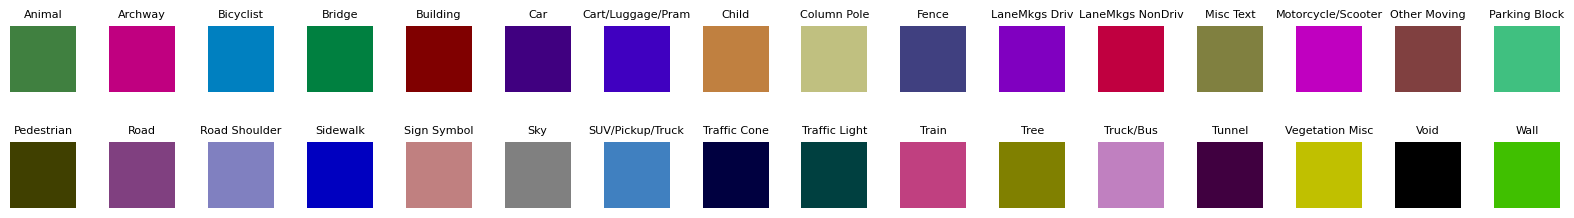

In [21]:
def plot_color_legend(class_index):
    # Extract colors and labels from class_index dictionary.
    color_array = np.array([[v[0][0], v[0][1], v[0][2]] for v in class_index.values()]).astype(np.uint8)
    class_labels = [val[1] for val in class_index.values()]

    fig, ax = plt.subplots(nrows=2, ncols=16, figsize=(20, 3))
    plt.subplots_adjust(wspace=0.5, hspace=0.01)

    # Display color legend.
    for i, axis in enumerate(ax.flat):
        axis.imshow(color_array[i][None, None, :])
        axis.set_title(class_labels[i], fontsize=8)
        axis.axis("off")
plot_color_legend(class_index)

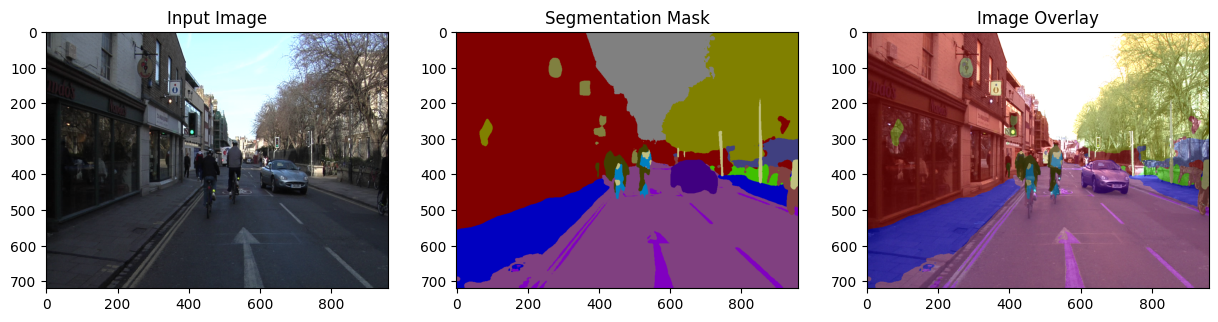

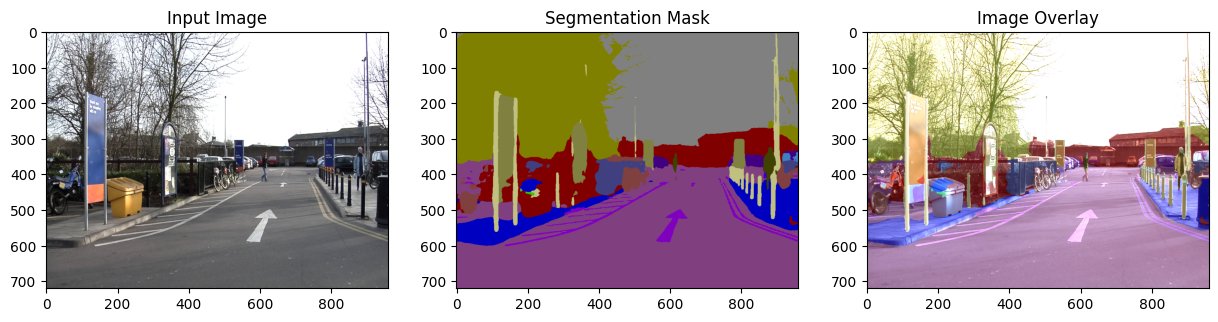

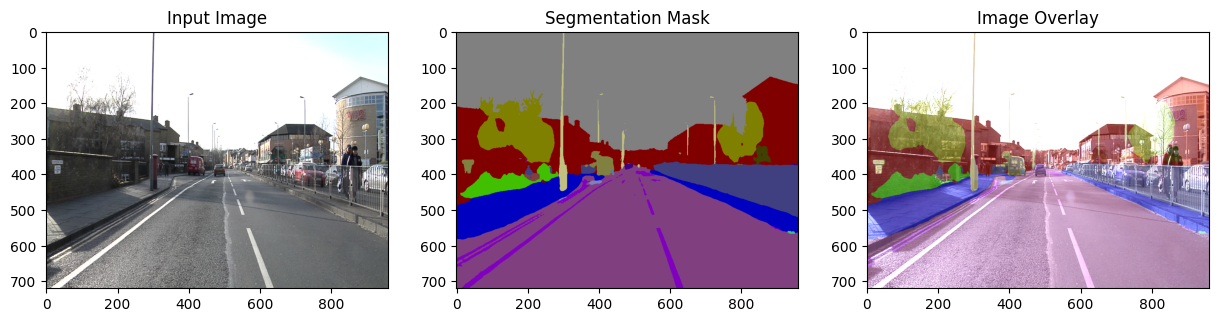

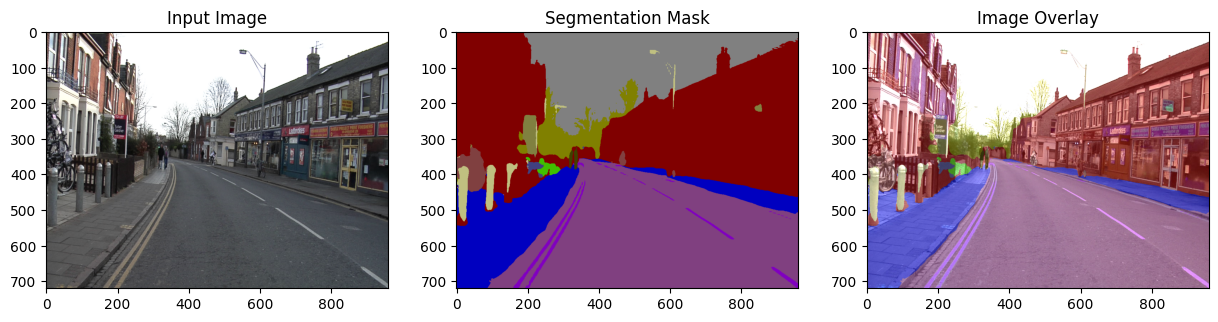

In [22]:
run_inference(images, seg_model)